In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from numpy.random import normal
from scipy.stats import sigmaclip
from astropy.coordinates import Distance
from astropy.cosmology import Planck18_arXiv_v2

from observable import draw_galaxies, observed_bands, beck_mag_cuts, estimate_photo_err

#%matplotlib widget
sns.set_theme(style='whitegrid')

In [2]:
# Load FRBs from the pickle files.
n_frbs = 1000
pickles = sorted(glob('Simulated_FRBs/*.pickle'))
survey_models, z_models = [], []
for file in pickles:
    # Extract models from file names.
    params = os.path.basename(file)
    params = os.path.splitext(params)[0]
    params = params.split('_', 1)
    survey_models.append(params[0])
    z_models.append(params[1])

In [4]:
# Pick an FRB survey and redshift distribution
chosen = pickles[4]
print(chosen)

Simulated_FRBs/chime-frb_smd.pickle


In [5]:
# Make bins around the catalog snapshots
bins = np.concatenate((snap_zs[0:1], snap_zs[:-1] + np.diff(snap_zs)/2, snap_zs[-1:] + 50.))

In [6]:
# Weight galaxy choice depending on file name
if os.path.splitext(chosen)[0][-3:] == 'sfr':  # last thre letters before extension
    weights = 'mstardot'
else:
    weights = 'mstars_total'

frbs = np.load(chosen, allow_pickle=True)
print(frbs.shape[0], "FRBs in file, using only first", n_frbs)
frbs = frbs.iloc[:n_frbs].copy() 

galaxies, snapnum = draw_galaxies(frbs['z'], weights=weights, seed=42)

# Order FRBs such that they correspond to galaxies at the same positions.
frbs.loc[:, 'snapnum'] = snapnum
frbs.sort_values('snapnum', ascending=True, inplace=True)

n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES = observed_bands(frbs, galaxies)

frbs['n_bands_SDSS'] = n_bands_obs_SDSS.to_numpy()
frbs['n_bands_LSST'] = n_bands_obs_LSST.to_numpy()
frbs['n_bands_Euclid'] = n_bands_obs_Euclid.to_numpy()
frbs['n_bands_DES'] = n_bands_obs_DES.to_numpy()

1011 FRBs in file, using only first 1000


/tmp/ipykernel_838969/387723103.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  galaxies = galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights='mstardot', random_state=seed))
/tmp/ipykernel_838969/387723103.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  galaxies = galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights='mstardot', random_state=seed))
/tmp/ipykernel_838969/387723103.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  galaxies = galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights='mstardot', random_state=seed))
/tmp/ipykernel_838969/387723103.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

(123236    5
 107455    5
 30971     5
 3034      5
 5767      5
          ..
 65249     0
 119855    0
 166624    0
 166334    0
 43327     0
 Length: 1000, dtype: int64,
 123236    6
 107455    6
 30971     6
 3034      6
 5767      6
          ..
 65249     0
 119855    0
 166624    0
 166334    0
 43327     0
 Length: 1000, dtype: int64,
 123236    4
 107455    4
 30971     4
 3034      4
 5767      4
          ..
 65249     0
 119855    0
 166624    0
 166334    0
 43327     0
 Length: 1000, dtype: int64)

In [7]:
# Get apparent magnitudes in SDSS
frb_zs = frbs['z'].to_numpy()
dist = Distance(z=frb_zs, cosmology=cosmo)
apparent_mag = (dist.distmod.value[:, np.newaxis] + 5*np.log10(cosmo.h)
                    - 2.5*np.log10(1+frb_zs)[:, np.newaxis]
                    + galaxies.loc[:, 'mag_SDSS-u_tot':'mag_SDSS-z_tot'])
mag_limits_SDSS = np.array([22.0, 22.2, 22.2, 21.3, 20.5])

In [8]:
apparent_mag_SDSS.rename(columns={'mag_SDSS-u_tot' : 'u', 
                                  'mag_SDSS-g_tot' : 'g', 
                                  'mag_SDSS-r_tot' : 'r',
                                  'mag_SDSS-i_tot' : 'i', 
                                  'mag_SDSS-z_tot' : 'z'},
                        inplace=True)

In [9]:
# Get real SDSS galaxies to estimate the errors.
sdss = pd.read_csv('Skyserver_SQL3_4_2022 4 21 09 PM.csv', delimiter=',', header=1)

ngal = sdss.shape[0]

# Save magnitudes and errors seperately.
bands = sdss.loc[:, 'u':'z':2]
errs = sdss.loc[:, 'err_u':'err_z':2]

# Exclude outliers.
not_outlier = (bands > -100).all(axis=1)
bands = bands[not_outlier]
errs = errs[not_outlier]

# Draw errors from the data statistics depending on the binned magnitudes.
sim_errs = pd.DataFrame(index=apparent_mag_SDSS.index)

# Simulate errors in each band.
for b, e in zip(bands, errs):
    # Define edges of magnitude bins. Make sure all magnitudes are inside.
    sim_errs[e], med_mag, std_mag, bins = estimate_photo_err(apparent_mag_SDSS[b], bands[b], errs[e], bins=30)


In [10]:
# Apply the SDSS magnitude cut?
apply_mag_cut = True

if apply_mag_cut:
    # Median 5-sigma depths
    # https://www.sdss.org/dr14/imaging/other_info/
    max_mag = np.array([22.15, 23.13, 22.70, 22.20, 20.71])
    bright_enough = (apparent_mag_SDSS < max_mag).all(1)

# Deterine which galaxies pass the Beck cuts assuming the real and est errors
beck_passed = beck_mag_cuts(apparent_mag_SDSS, sim_errs, verbose=False)

reliable_photometry = bright_enough & beck_passed
print(f"{bright_enough.sum()} out of {bright_enough.shape[0]} galaxies have sufficient magnitude, "
      f"{beck_passed.sum()} pass the color tests, {reliable_photometry.sum()} pass both.")

208 out of 1000 galaxies have sufficient magnitude, 286 pass the color tests, 204 pass both.


In [11]:
# Same with original data
bright_enough_real = (bands < max_mag).all(1)

# Deterine which galaxies pass the Beck cuts assuming the real and est errors
beck_passed_real = beck_mag_cuts(bands, errs, verbose=False)

reliable_photometry_real = bright_enough_real & beck_passed_real
print(f"{bright_enough_real.sum()} out of {bright_enough_real.shape[0]} galaxies have sufficient magnitude, "
      f"{beck_passed_real.sum()} pass the color tests, {reliable_photometry_real.sum()} pass both.")

12570 out of 99999 galaxies have sufficient magnitude, 33035 pass the color tests, 10905 pass both.


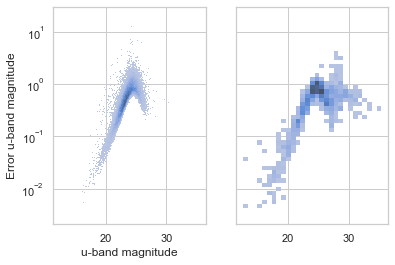

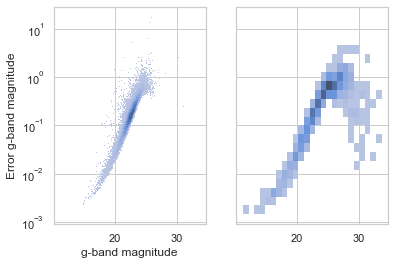

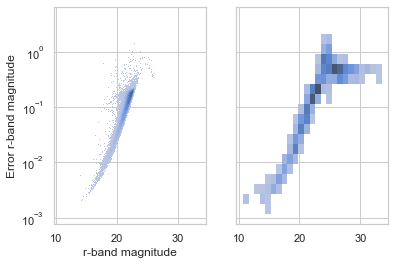

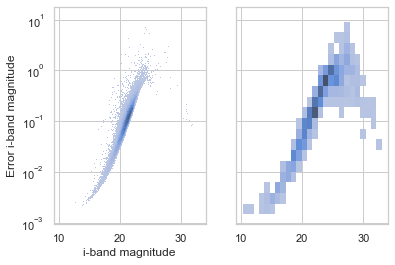

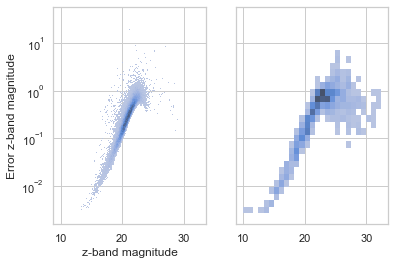

In [12]:
#Plot photometry and errors
for b, e in zip(bands, errs):
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    
    sns.histplot(x=bands[b], y=errs[e], ax=ax[0])
    sns.histplot(x=apparent_mag_SDSS[b].to_numpy(), y=sim_errs[e].to_numpy(), ax=ax[1])

    #plt.legend()
    ax[0].set_xlabel(f'{bands[b].name}-band magnitude')
    ax[0].set_ylabel(f'Error {bands[b].name}-band magnitude')

In [15]:
#Calculate color differences. Could use bands.diff(periods=-1, axis=1)
ugcolor = bands['u'] - bands['g']
grcolor = bands['g'] - bands['r']
ricolor = bands['r'] - bands['i']
izcolor = bands['i'] - bands['z']

err_gr = np.sqrt(errs['err_g']**2 + errs['err_r']**2)
err_ri = np.sqrt(errs['err_r']**2 + errs['err_i']**2)
err_iz = np.sqrt(errs['err_i']**2 + errs['err_z']**2)

ugcolor_sim = apparent_mag_SDSS['u'] - apparent_mag_SDSS['g']
grcolor_sim = apparent_mag_SDSS['g'] - apparent_mag_SDSS['r']
ricolor_sim = apparent_mag_SDSS['r'] - apparent_mag_SDSS['i']
izcolor_sim = apparent_mag_SDSS['i'] - apparent_mag_SDSS['z']

err_gr_sim = np.sqrt(sim_errs['err_g']**2 + sim_errs['err_r']**2)
err_ri_sim = np.sqrt(sim_errs['err_r']**2 + sim_errs['err_i']**2)
err_iz_sim = np.sqrt(sim_errs['err_i']**2 + sim_errs['err_z']**2)

In [16]:
vinds_est = beck_passed
vinds_real = beck_mag_cuts(bands, errs, verbose=False)

Text(0, 0.5, 'iz color error')

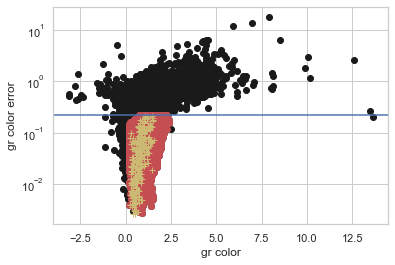

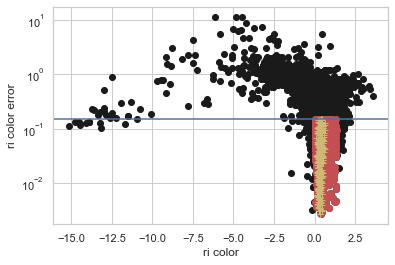

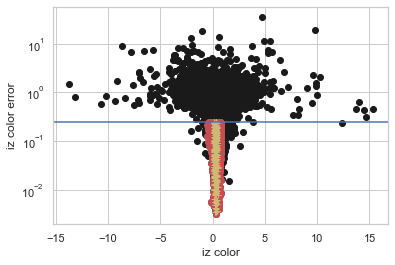

In [17]:
#Plot colors and errors
plt.figure()
plt.plot(grcolor, err_gr, 'ko')
plt.plot(grcolor[vinds_real], err_gr[vinds_real], 'ro')
plt.plot(grcolor_sim[vinds_est], err_gr_sim[vinds_est], 'y+')
plt.axhline(0.225)
plt.yscale('log')

plt.xlabel('gr color')
plt.ylabel('gr color error')

plt.figure()
plt.plot(ricolor, err_ri, 'ko')
plt.plot(ricolor[vinds_real], err_ri[vinds_real], 'ro')
plt.plot(ricolor_sim[vinds_est], err_ri_sim[vinds_est], 'y+')
plt.axhline(0.15)
plt.yscale('log')

plt.xlabel('ri color')
plt.ylabel('ri color error')

plt.figure()
plt.plot(izcolor, err_iz, 'ko')
plt.plot(izcolor[vinds_real], err_iz[vinds_real], 'ro')
plt.plot(izcolor_sim[vinds_est], err_iz_sim[vinds_est], 'y+')
plt.axhline(0.25)
plt.yscale('log')

plt.xlabel('iz color')
plt.ylabel('iz color error')

Text(0.5, 0, 'magnitude')

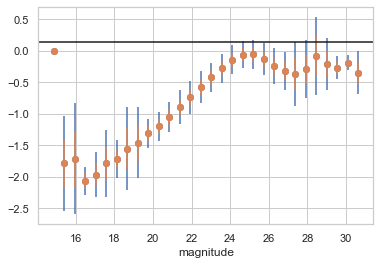

In [18]:
#Compare estimated statistics with true scatter in the data
myband = bands['u']
merr,med_mag,std_mag, bins = estimate_photo_err(bands['u'], bands['u'], errs['err_u'], bins=30)

#This plot doesn't make sense. Rethink
#py.plot(myband[0], myband[1], 'r+')
#py.errorbar(bins, med_mag, yerr=std_mag, fmt='o')
#py.xlabel('magnitude bin')
#py.ylabel('median error')

plt.figure()
plt.errorbar(bins, med_mag, yerr=2*std_mag, fmt='o')
plt.errorbar(bins, med_mag, yerr=std_mag, fmt='o')
plt.axhline(0.15, color='k')
plt.xlabel('magnitude')
#plt.xlim((14,22))
#plt.ylim((0,0.2))

In [19]:
dr16_bright = (apparent_mag_SDSS < mag_limits_SDSS).all(1)
bright_enough = (apparent_mag_SDSS < max_mag).all(1)

In [20]:
dr16_bright.sum(), bright_enough.sum(), (dr16_bright | bright_enough).sum(), reliable_photometry.sum()


(197, 208, 208, 204)

In [26]:
n_bands_obs = frbs['n_bands_SDSS']
n_bands = n_bands_obs.max()
#n_observed_sdss[i] = np.histogram(frbs.loc[n_bands_obs.to_numpy() == n_bands, 'z'], bins=np.linspace(0, z_max[0], n_z_bins+1))[0]

In [27]:
frbs.loc[n_bands_obs.to_numpy() == n_bands, 'z']

38     0.02240
66     0.06402
15     0.05099
119    0.11907
76     0.07836
        ...   
42     0.13771
47     0.20061
70     0.21236
75     0.40269
66     0.39860
Name: z, Length: 197, dtype: float32

(array([98., 77., 24.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
        1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
        2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
        2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ]),
 <BarContainer object of 29 artists>)

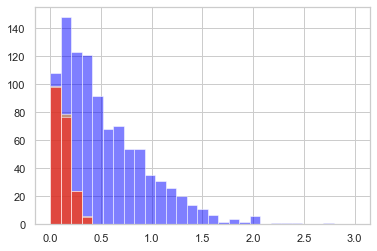

In [28]:
fig, ax = plt.subplots()
ax.hist(frbs['z'], density=False, alpha=0.5, bins=np.linspace(0, 3, 30), color='blue')  #bins[bins<2]
ax.hist(frbs.loc[bright_enough.to_numpy(), 'z'], density=False, alpha=0.5, bins=np.linspace(0, 3, 30), color='orange')
ax.hist(frbs.loc[reliable_photometry.to_numpy(), 'z'], density=False, alpha=0.5, bins=np.linspace(0, 3, 30), color='red')